# Detector response

We have already considered the energy spread in the IBD process. There are two additional processes to consider:

* The nonlinear response of liquid scintillator (LSNL in JUNO paper). We use a nominal curve to translate $E_{\mathrm{dep}}$ to $E_{\mathrm{vis}}$, of which the latter is proportional to the expected number of photons.

* The energy resolution of the detector, applied on $E_{\mathrm{vis}}$ to $E_{\mathrm{rec}}$.

There are difficulties associated with both steps, In the nonlinear response step, we need smooth functions, but we only have a figure (Fig 2). Extracting data from the figure will inevitably introduce artificial wiggles. To solve this, a polynomial fit is performed.

The difficulty mainly lies in the second step, where a convolution is necessary. We use the matrix multiplification method to save computing time, and build a response matrix (R-matrix) that reflects how the detector translates $E_{\nu}$ to $E_{\mathrm{rec}}$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "figure.figsize": (6.4, 4.8),
        "figure.dpi": 600,
        "font.family": "serif",
        "font.size": 15,
        # 'figure.dpi': 300,
        "lines.linewidth": 2.0,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.major.size": 8,
        "xtick.minor.size": 4,
        "ytick.major.size": 8,
        "ytick.minor.size": 4,
        "xtick.major.width": 1,
        "xtick.minor.width": 0.7,
        "ytick.major.width": 1,
        "ytick.minor.width": 0.7,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "legend.loc": "upper center",
        "legend.fancybox": True,  # if True, use a rounded box for the
        # legend background, else a rectangle
        "legend.fontsize": 15,
        "text.usetex": True,
    }
)

In [2]:
from detector_response import JUNODetector
from ibd_kinematics import StrumiaVissani

sv = StrumiaVissani()
juno_detector = JUNODetector(sv)

First, we demonstrate the method of the polynomial fit.

In [3]:
non_linear_data = np.loadtxt("data/non_linear_response.csv", delimiter=",")

E_dep_data = non_linear_data[:, 0]
ratio = non_linear_data[:, 1]
E_vis_data = E_dep_data * ratio

# Forward fit: E_dep(E_vis)
deg_fwd = 5
coeffs_fwd = np.polyfit(E_vis_data, E_dep_data, deg_fwd)


def E_dep_from_E_vis(E_vis):
    return np.polyval(coeffs_fwd, E_vis)


dcoeffs_fwd = np.polyder(coeffs_fwd)


def dE_dep_dE_vis(E_vis):
    return np.polyval(dcoeffs_fwd, E_vis)


# Inverse fit: E_vis(E_dep)
deg_inv = 5
coeffs_inv = np.polyfit(E_dep_data, E_vis_data, deg_inv)


def E_vis_from_E_dep(E_dep):
    return np.polyval(coeffs_inv, E_dep)


dcoeffs_inv = np.polyder(coeffs_inv)


def dE_vis_dE_dep(E_dep):
    return np.polyval(dcoeffs_inv, E_dep)

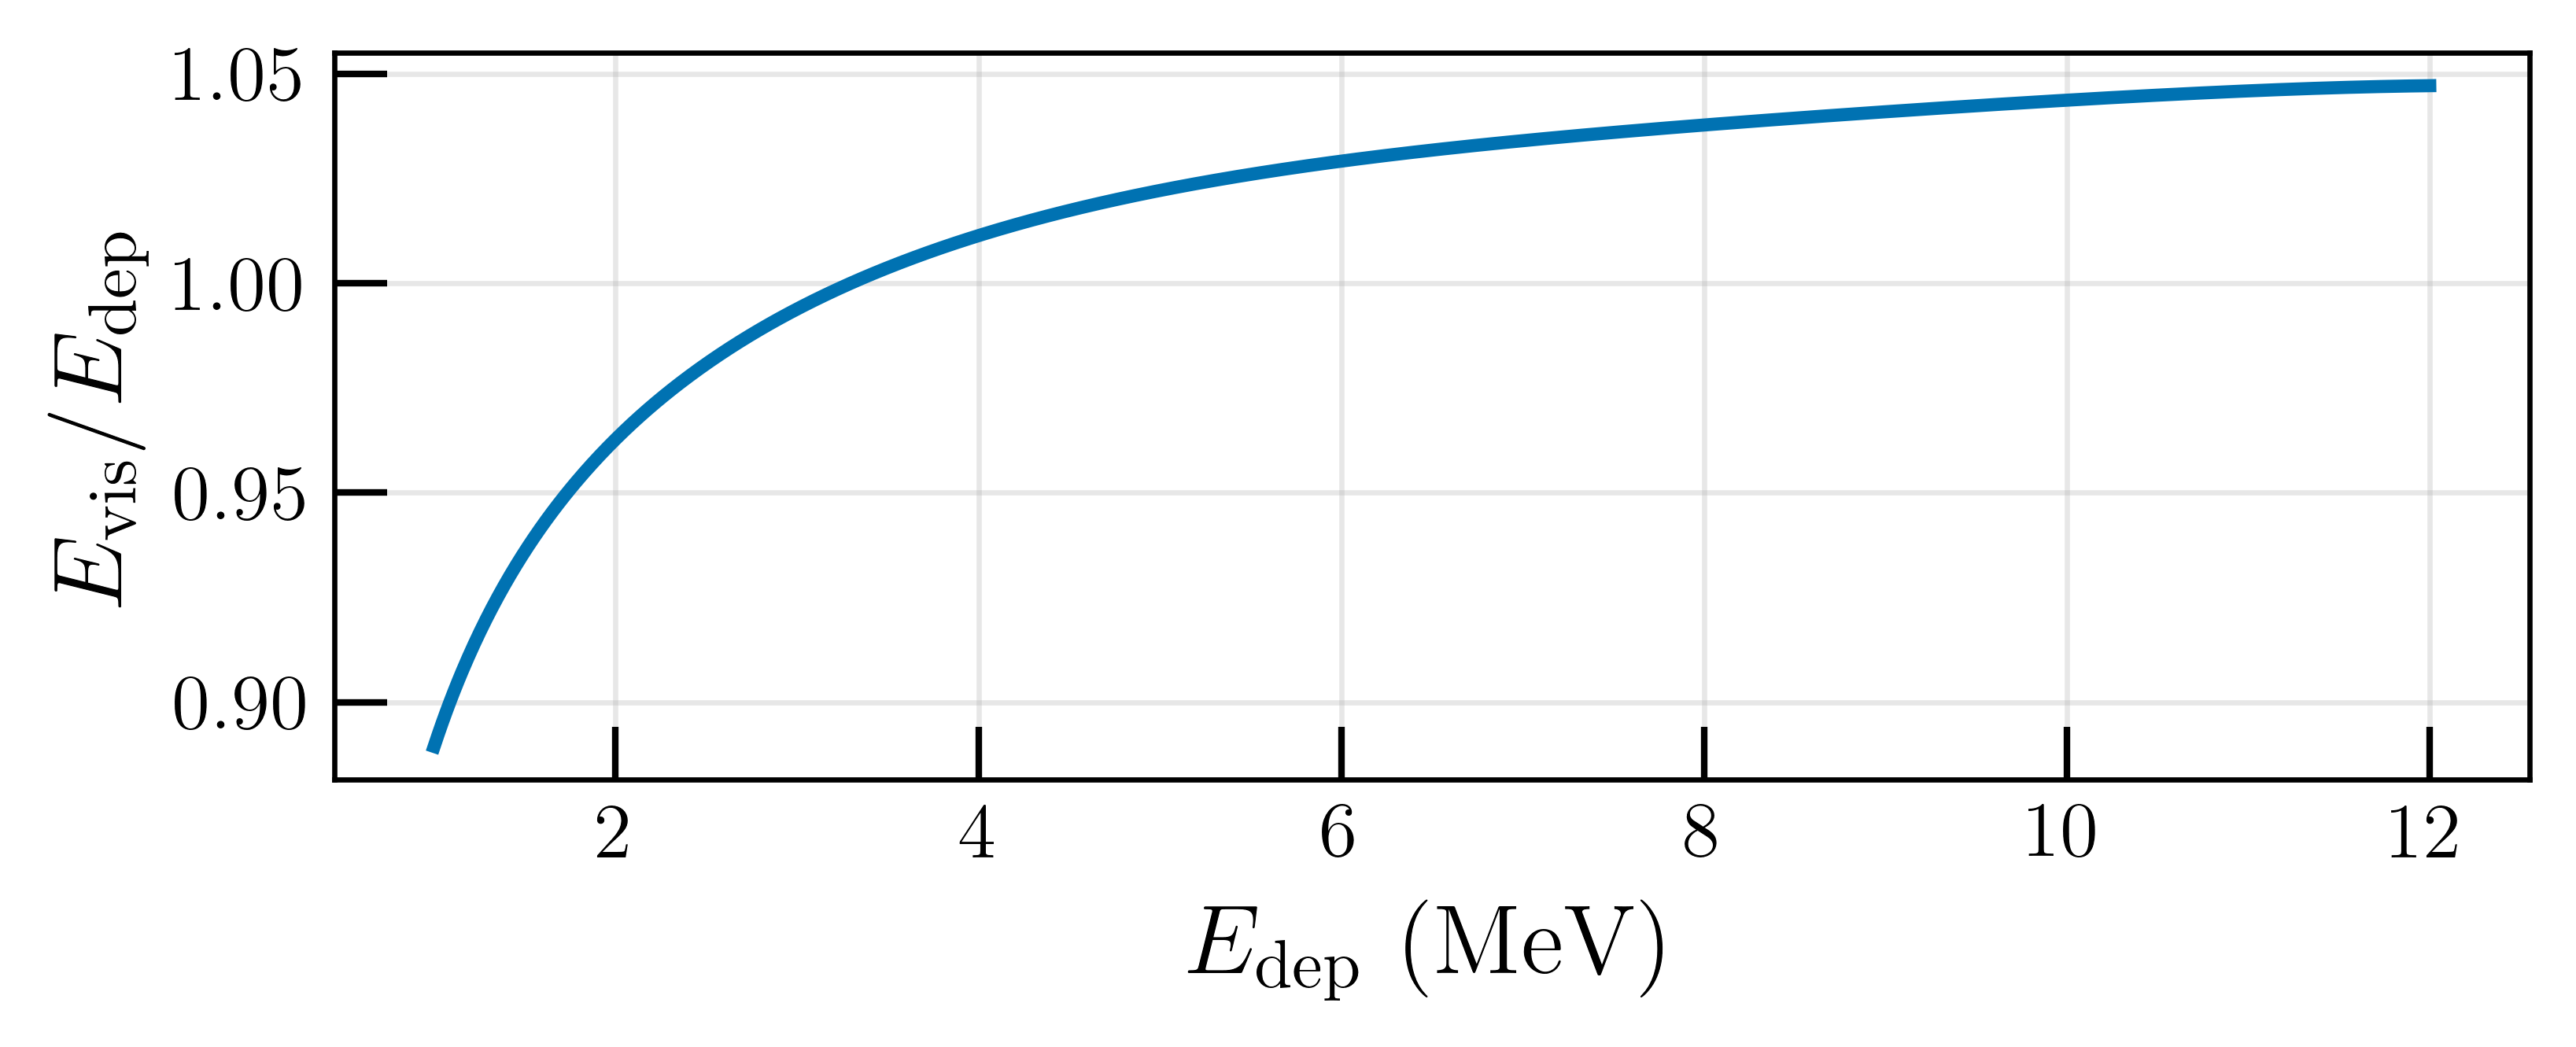

In [24]:
test_E_dep = np.linspace(1, 12, 1000)
test_E_vis = E_vis_from_E_dep(test_E_dep)
plt.figure(figsize=(6, 2))
plt.plot(
    test_E_dep,
    test_E_vis / test_E_dep,
    # label="Polynomial Fit",
)
plt.xlabel(r"$E_{\mathrm{dep}}$ (MeV)")
plt.ylabel(r"$E_{\mathrm{vis}} / E_{\mathrm{dep}}$")
plt.grid(True, alpha=0.3)
plt.savefig("./plots/juno_non_linear_response_curve.pdf", bbox_inches="tight")

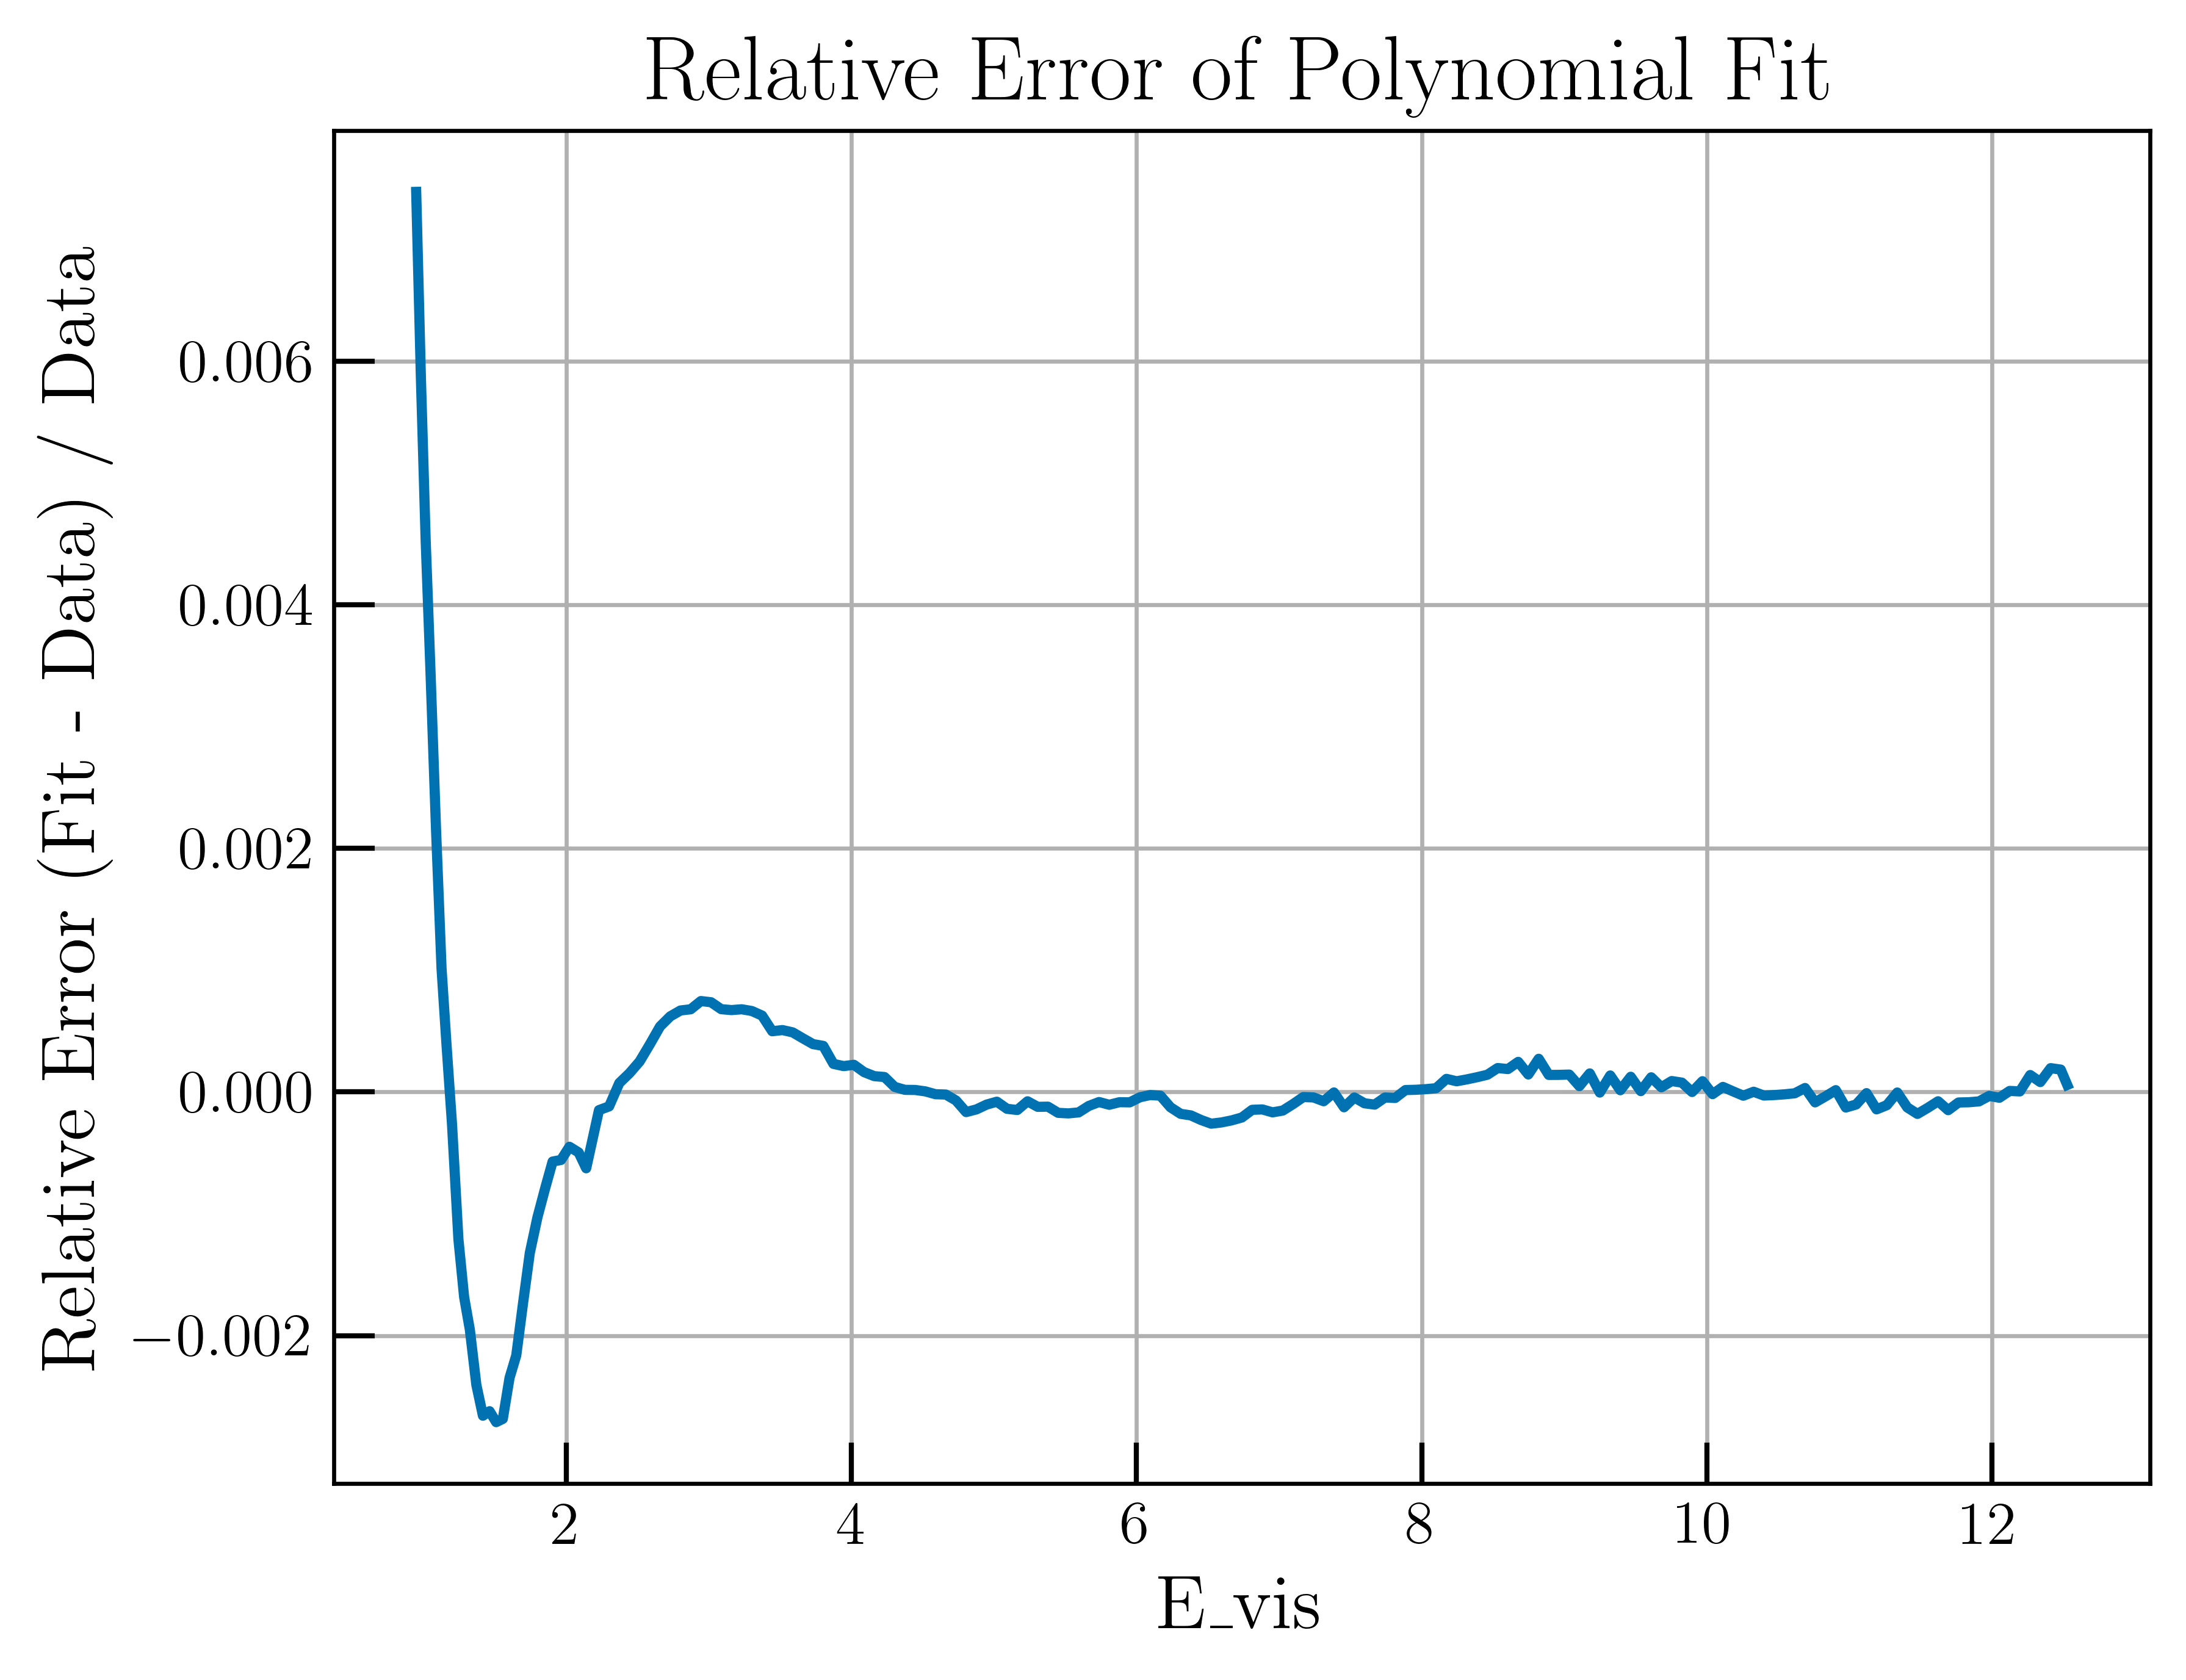

In [4]:
# We check the numerical error of the two fits
Edep_fit = np.polyval(coeffs_fwd, E_vis_data)

# Compute relative error
relative_error = (Edep_fit - E_dep_data) / E_dep_data

# Plot relative error
plt.figure()
plt.plot(E_vis_data, relative_error)
plt.xlabel("E_vis")
plt.ylabel("Relative Error (Fit - Data) / Data")
plt.title("Relative Error of Polynomial Fit")
plt.grid(True)
plt.show()

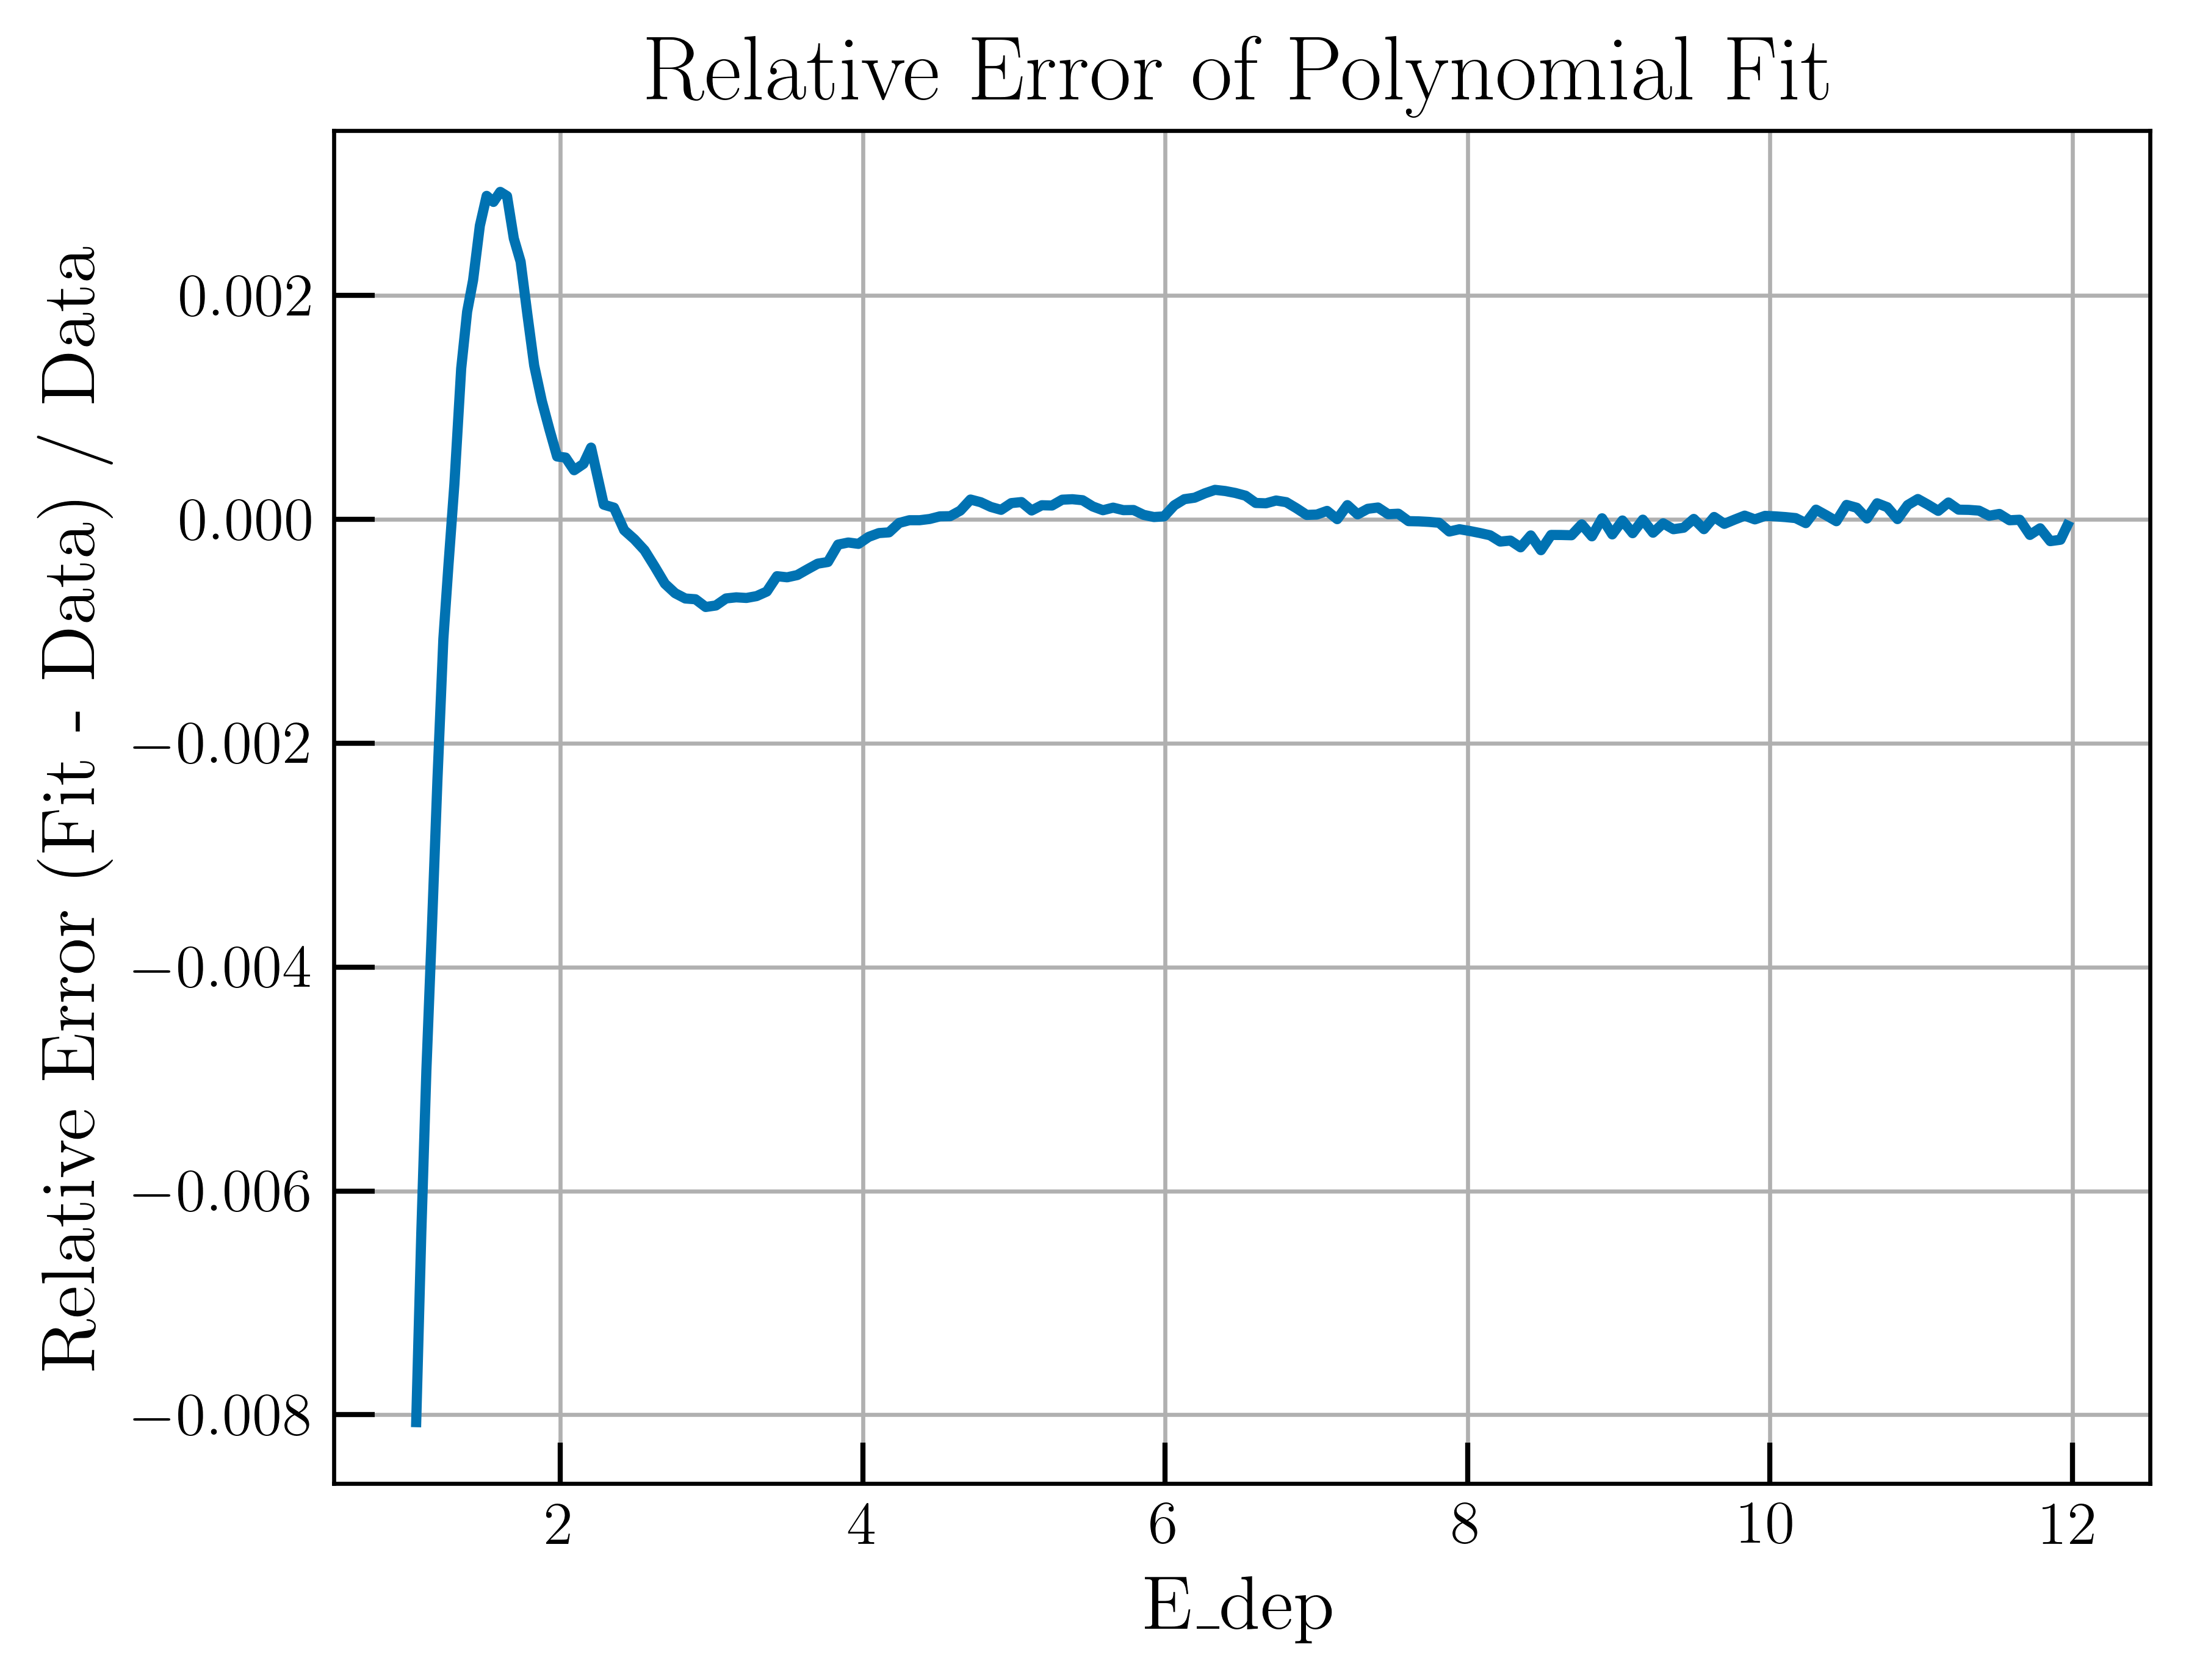

In [5]:
Evis_fit = np.polyval(coeffs_inv, E_dep_data)

# Compute relative error
relative_error_inv = (Evis_fit - E_vis_data) / E_vis_data

# Plot relative error
plt.figure()
plt.plot(E_dep_data, relative_error_inv)
plt.xlabel("E_dep")
plt.ylabel("Relative Error (Fit - Data) / Data")
plt.title("Relative Error of Polynomial Fit")
plt.grid(True)
plt.show()

Max E_vis round-trip relative error: 0.0003064370601250312


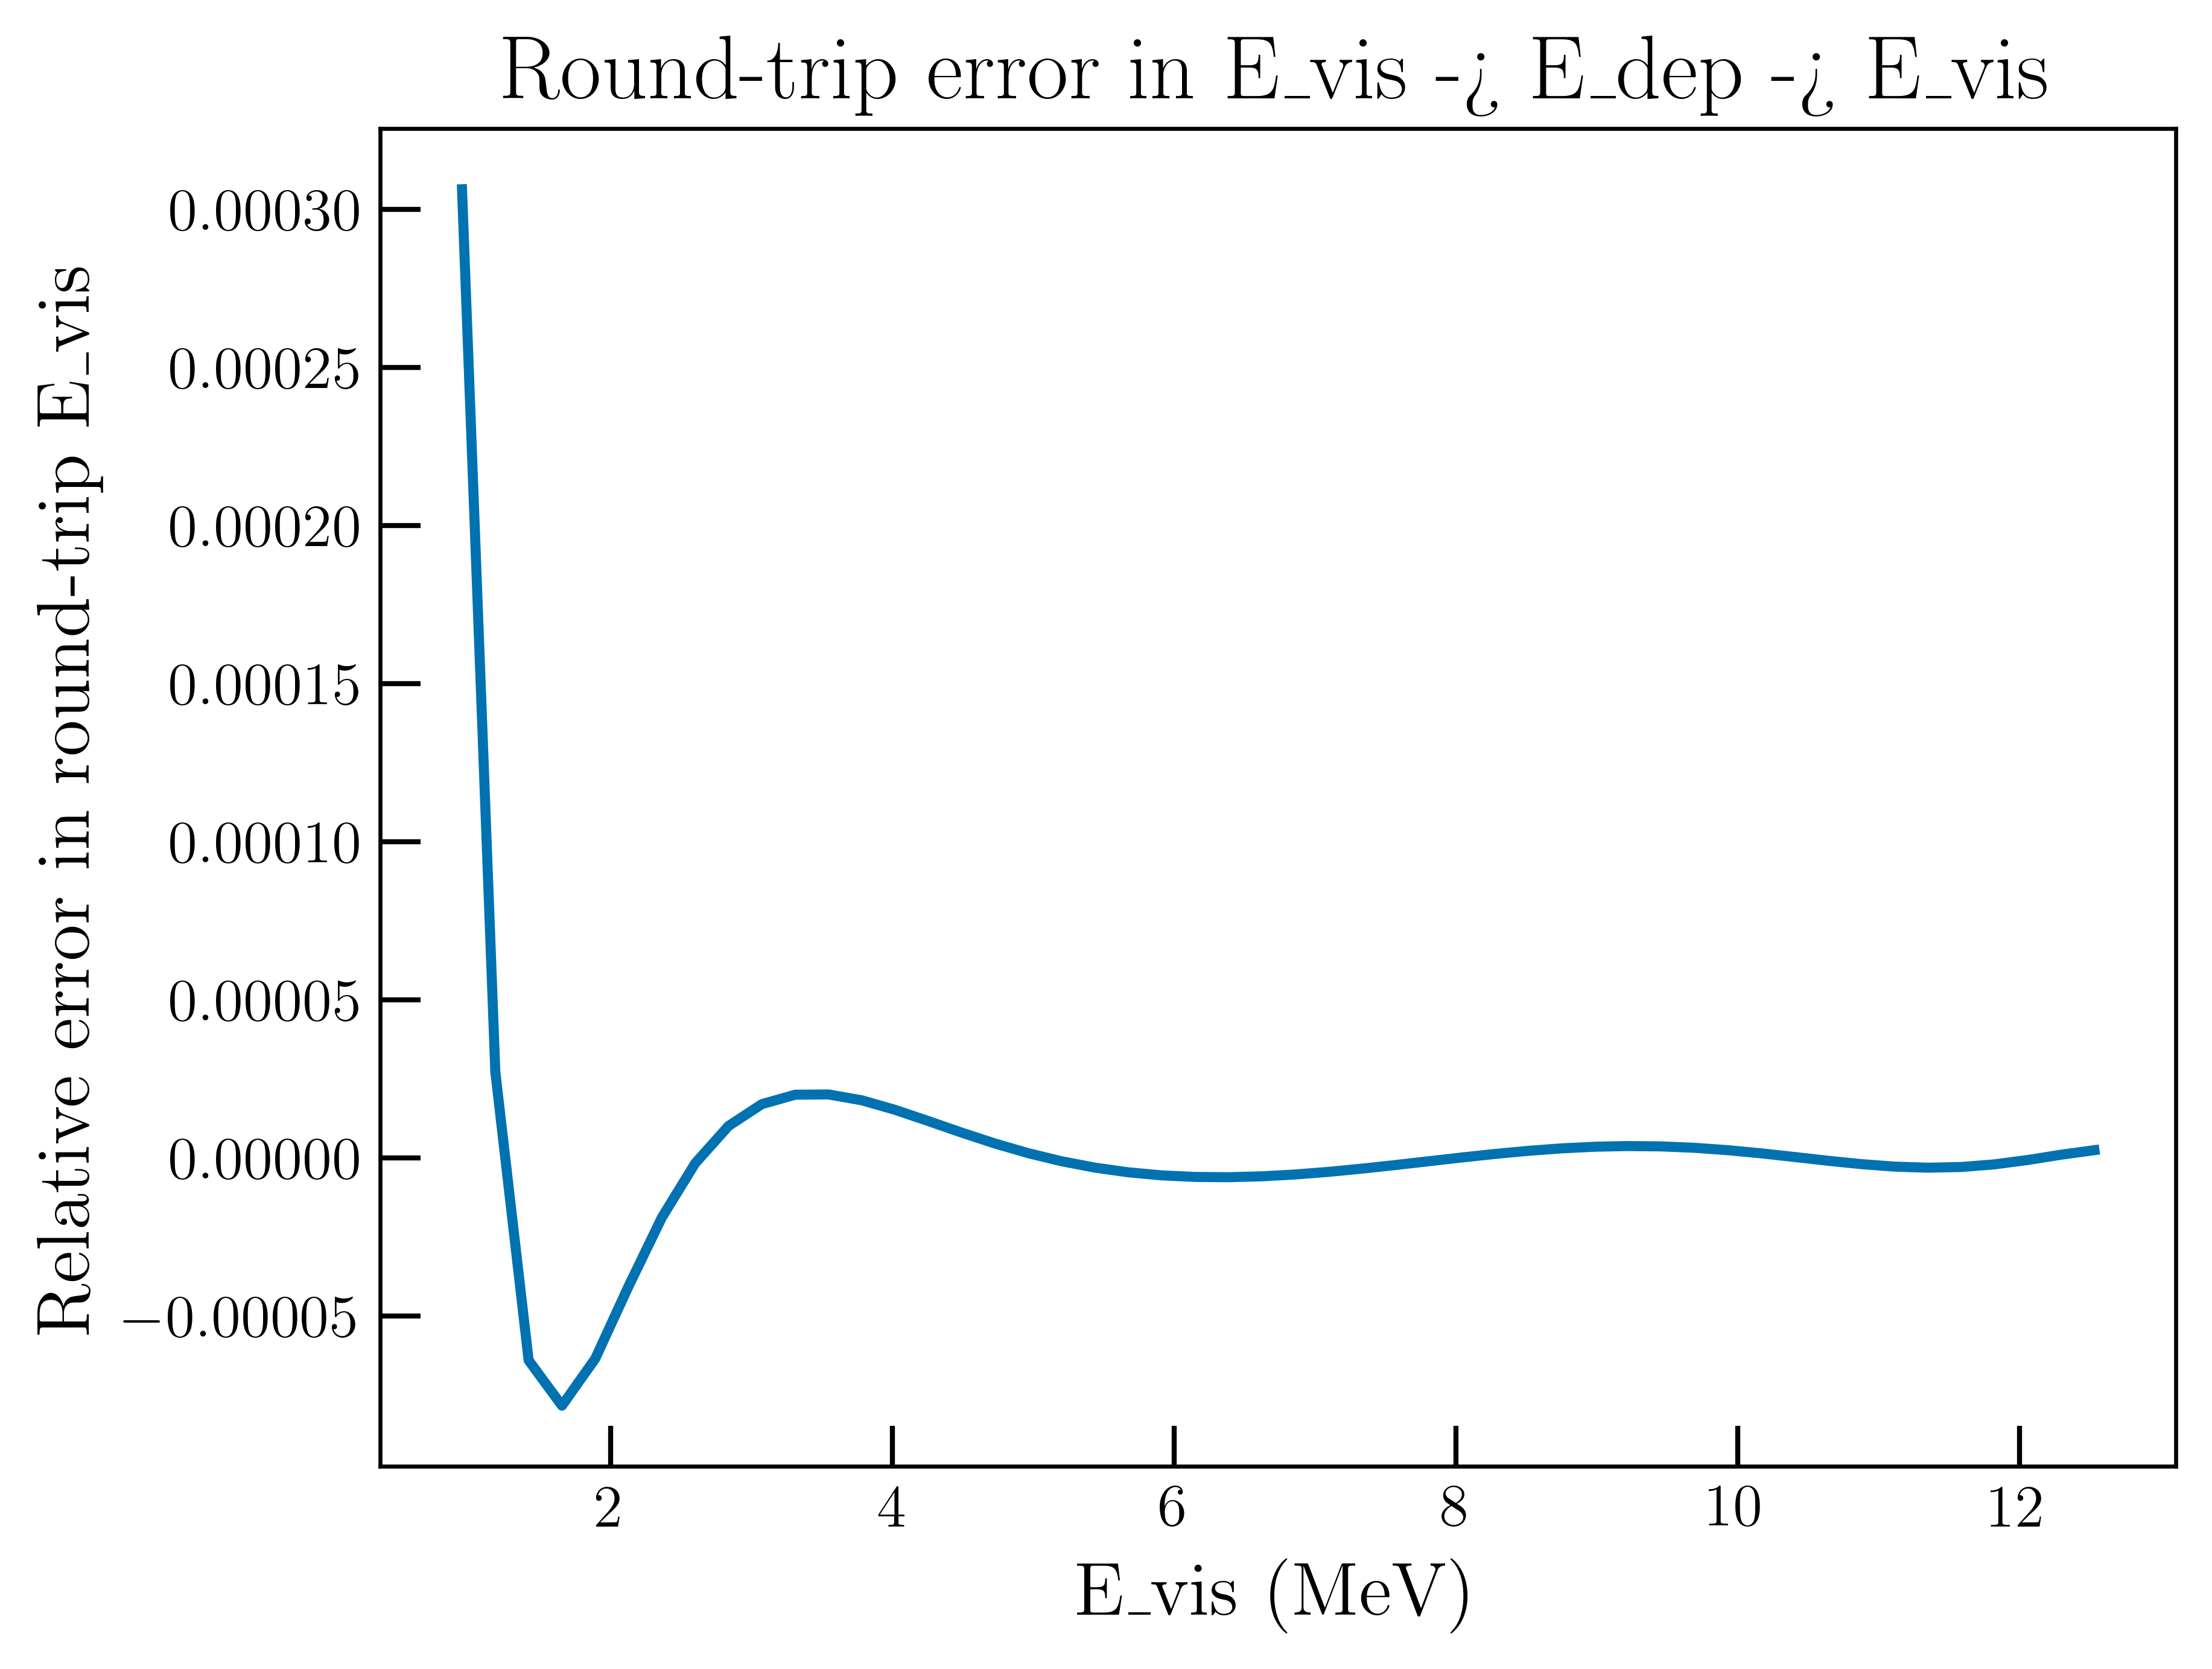

In [6]:
# Consistency check (round-trip test):
test = np.linspace(E_vis_data.min(), E_vis_data.max(), 50)

Edep_rt = E_dep_from_E_vis(test)
Evis_rt = E_vis_from_E_dep(Edep_rt)

roundtrip_err = (Evis_rt - test) / test
print("Max E_vis round-trip relative error:", np.max(np.abs(roundtrip_err)))
plt.plot(test, roundtrip_err)
plt.xlabel("E_vis (MeV)")
plt.ylabel("Relative error in round-trip E_vis")
plt.title("Round-trip error in E_vis -> E_dep -> E_vis")
plt.show()

The relative error is on the order of 0.1% for the mid-energy range, smaller than the error of the figure extraction. We conclude that this is good enough for our purpose.

Next, we evaluate the precision of the matrix multiplication method with respect to the more accurate but slower `quad` implementation.

/home/mhliu/Documents/juno-sensitivity/detector_response.py:132: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, abs_error = scipy.integrate.quad(integrand, E_vis_min, E_vis_max)


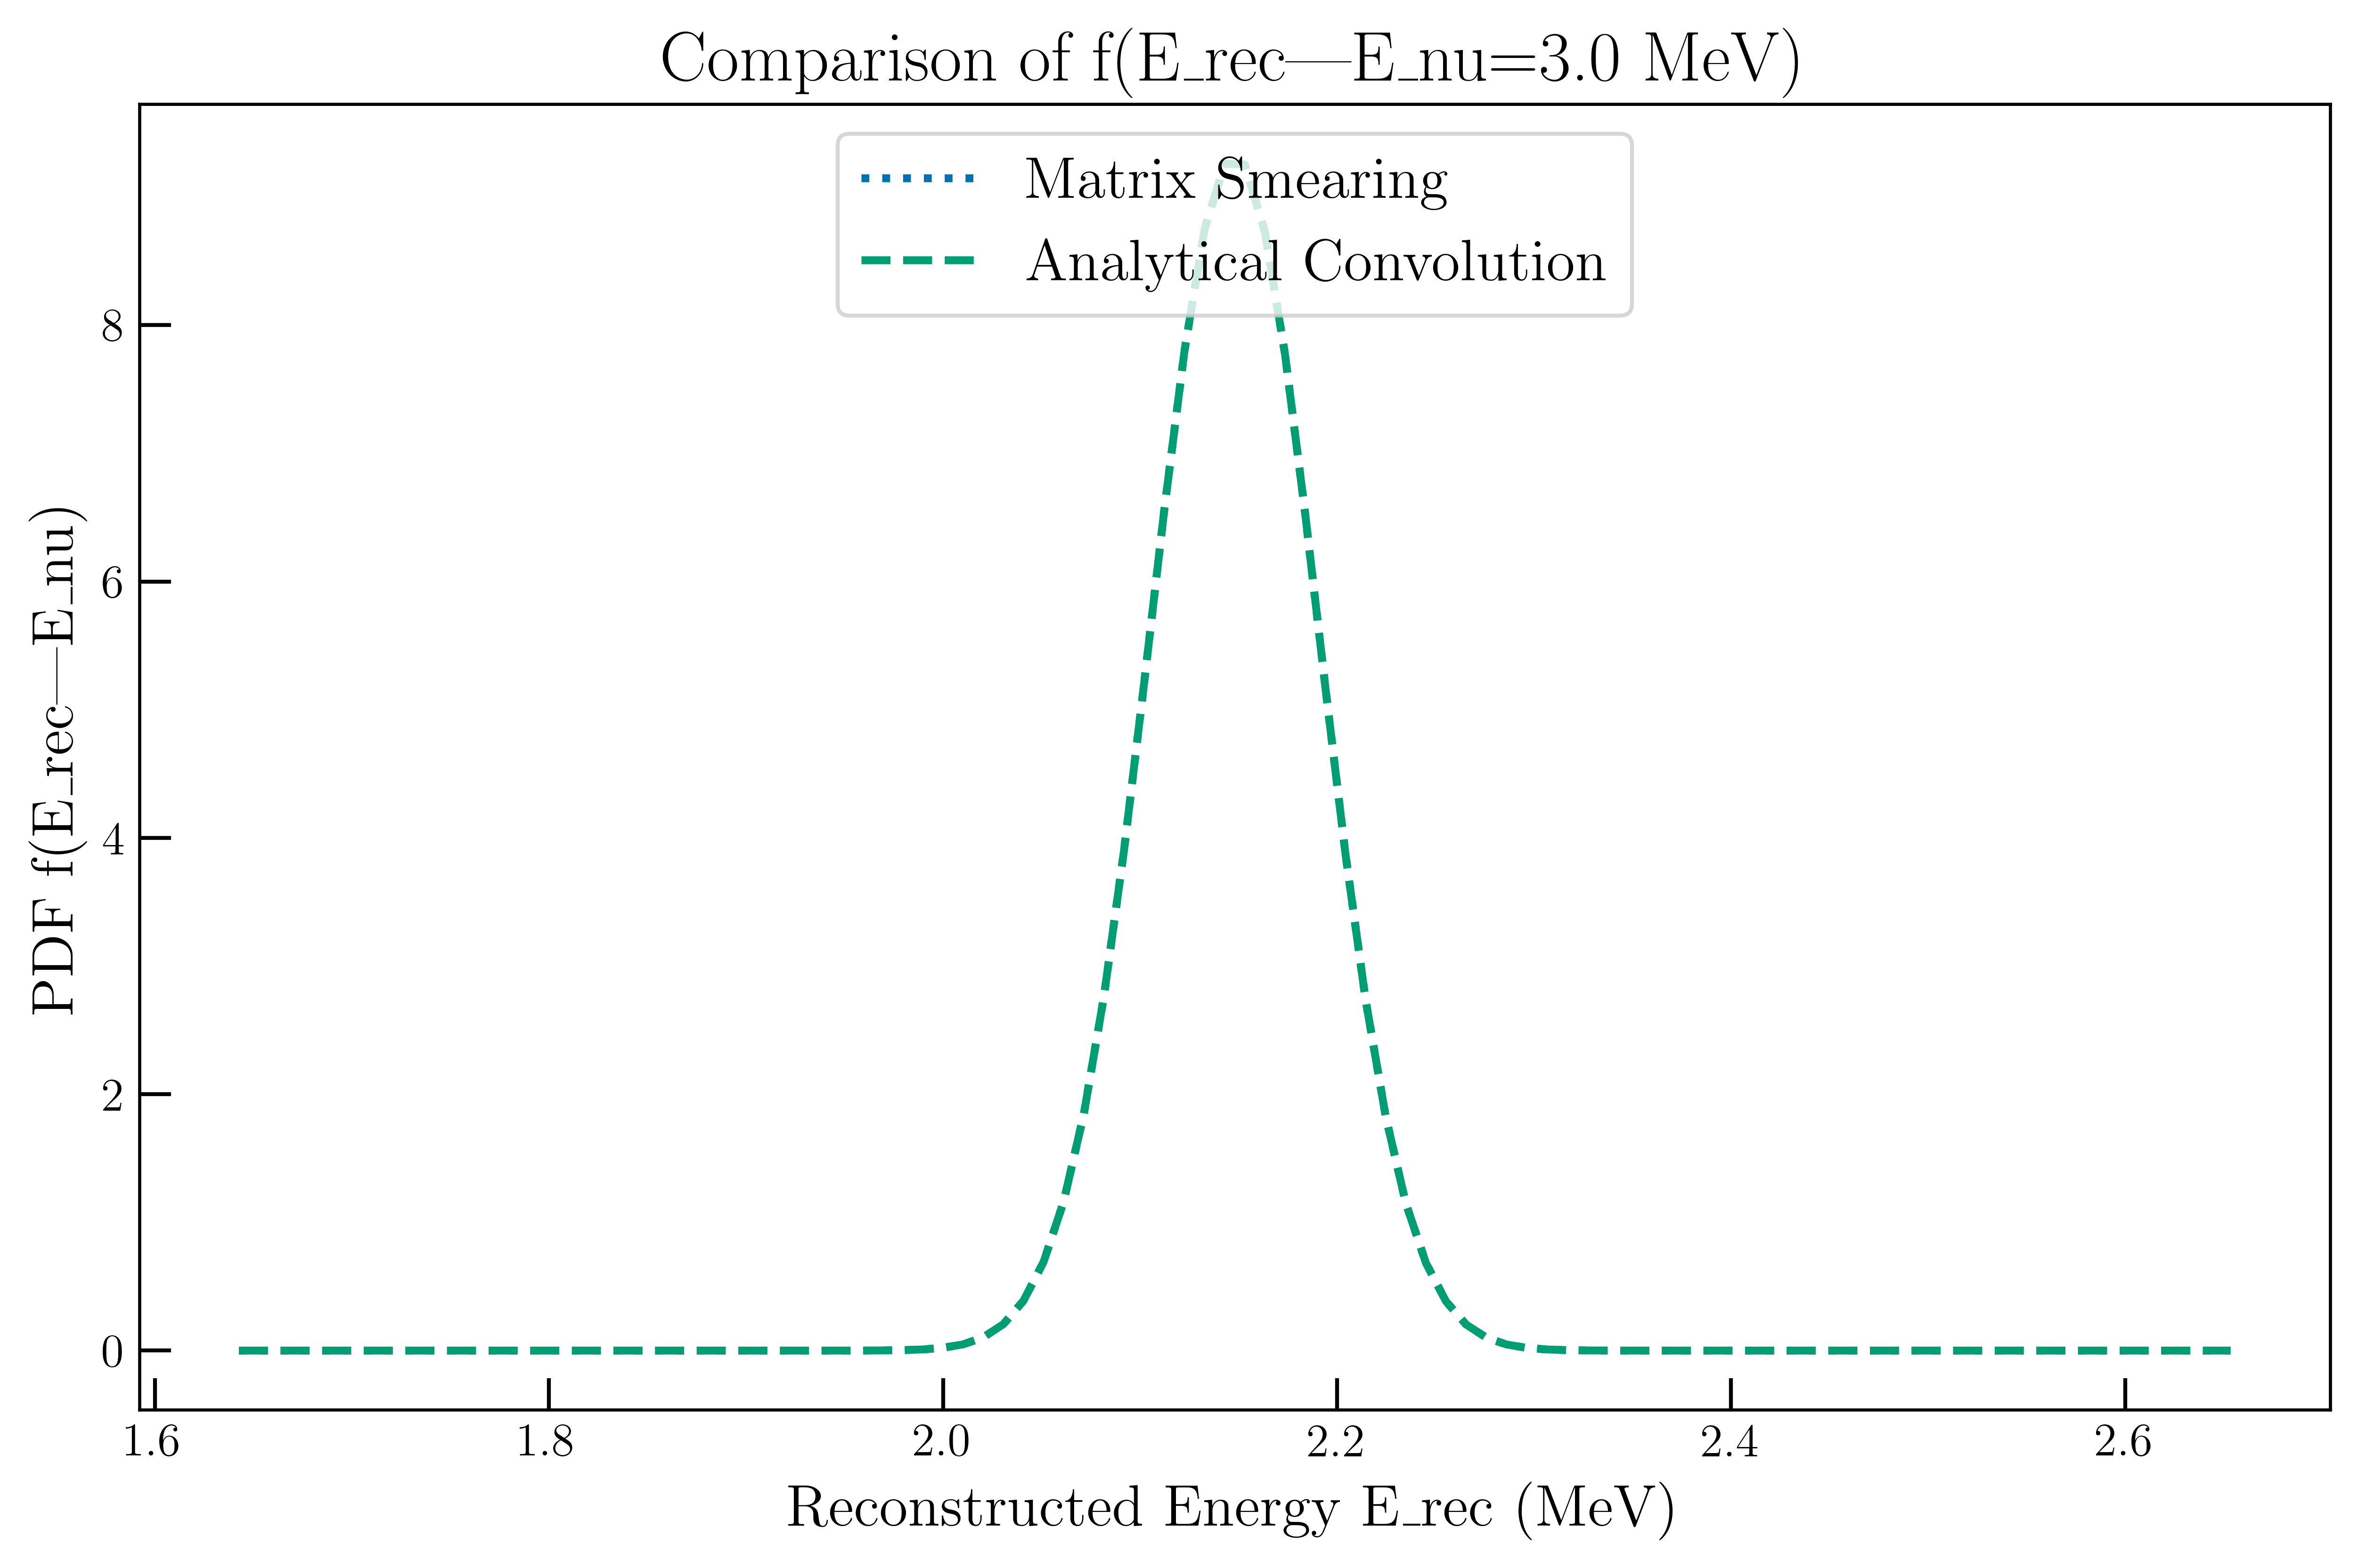

In [7]:
E_nu = 3.0  # MeV
E_dep_pdf = sv.get_E_dep_pdf
E_e_min, E_e_max = sv.get_kinematic_bounds(E_nu)
E_dep_min = E_e_min[0] + sv.m_e
E_dep_max = E_e_max[0] + sv.m_e
E_vis_min = juno_detector.spline_dep_to_vis(E_dep_min)
E_vis_max = juno_detector.spline_dep_to_vis(E_dep_max)
E_rec_pdf = juno_detector.get_E_rec_pdf(
    E_dep_pdf=E_dep_pdf, E_dep_min=E_dep_min, E_dep_max=E_dep_max
)

# We compute the matrix-smearing result
grid_vis = np.linspace(E_vis_min, E_vis_max, 1001)  # Grid for E_vis
grid_rec = np.linspace(E_vis_min - 0.5, E_vis_max + 0.5, 100)  # Grid for E_rec

pdf_vis = juno_detector.get_E_vis_pdf(sv.get_E_dep_pdf)(E_nu, grid_vis)
pdf_rec = juno_detector.get_E_rec_pdf_grid(grid_vis, grid_rec, pdf_vis)

# For comparison, compute the analytical convolution result
analytical_pdf_rec = np.array([E_rec_pdf(E_nu, E) for E in grid_rec])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grid_rec, pdf_rec, label="Matrix Smearing", linestyle="dotted")
# analytical_pdf_rec = np.array([E_rec_pdf(E_nu, E) for E in grid_rec])
plt.plot(
    grid_rec, analytical_pdf_rec, label="Analytical Convolution", linestyle="dashed"
)
plt.xlabel("Reconstructed Energy E_rec (MeV)")
plt.ylabel("PDF f(E_rec|E_nu)")
plt.title(f"Comparison of f(E_rec|E_nu={E_nu} MeV)")
plt.legend()
plt.show()

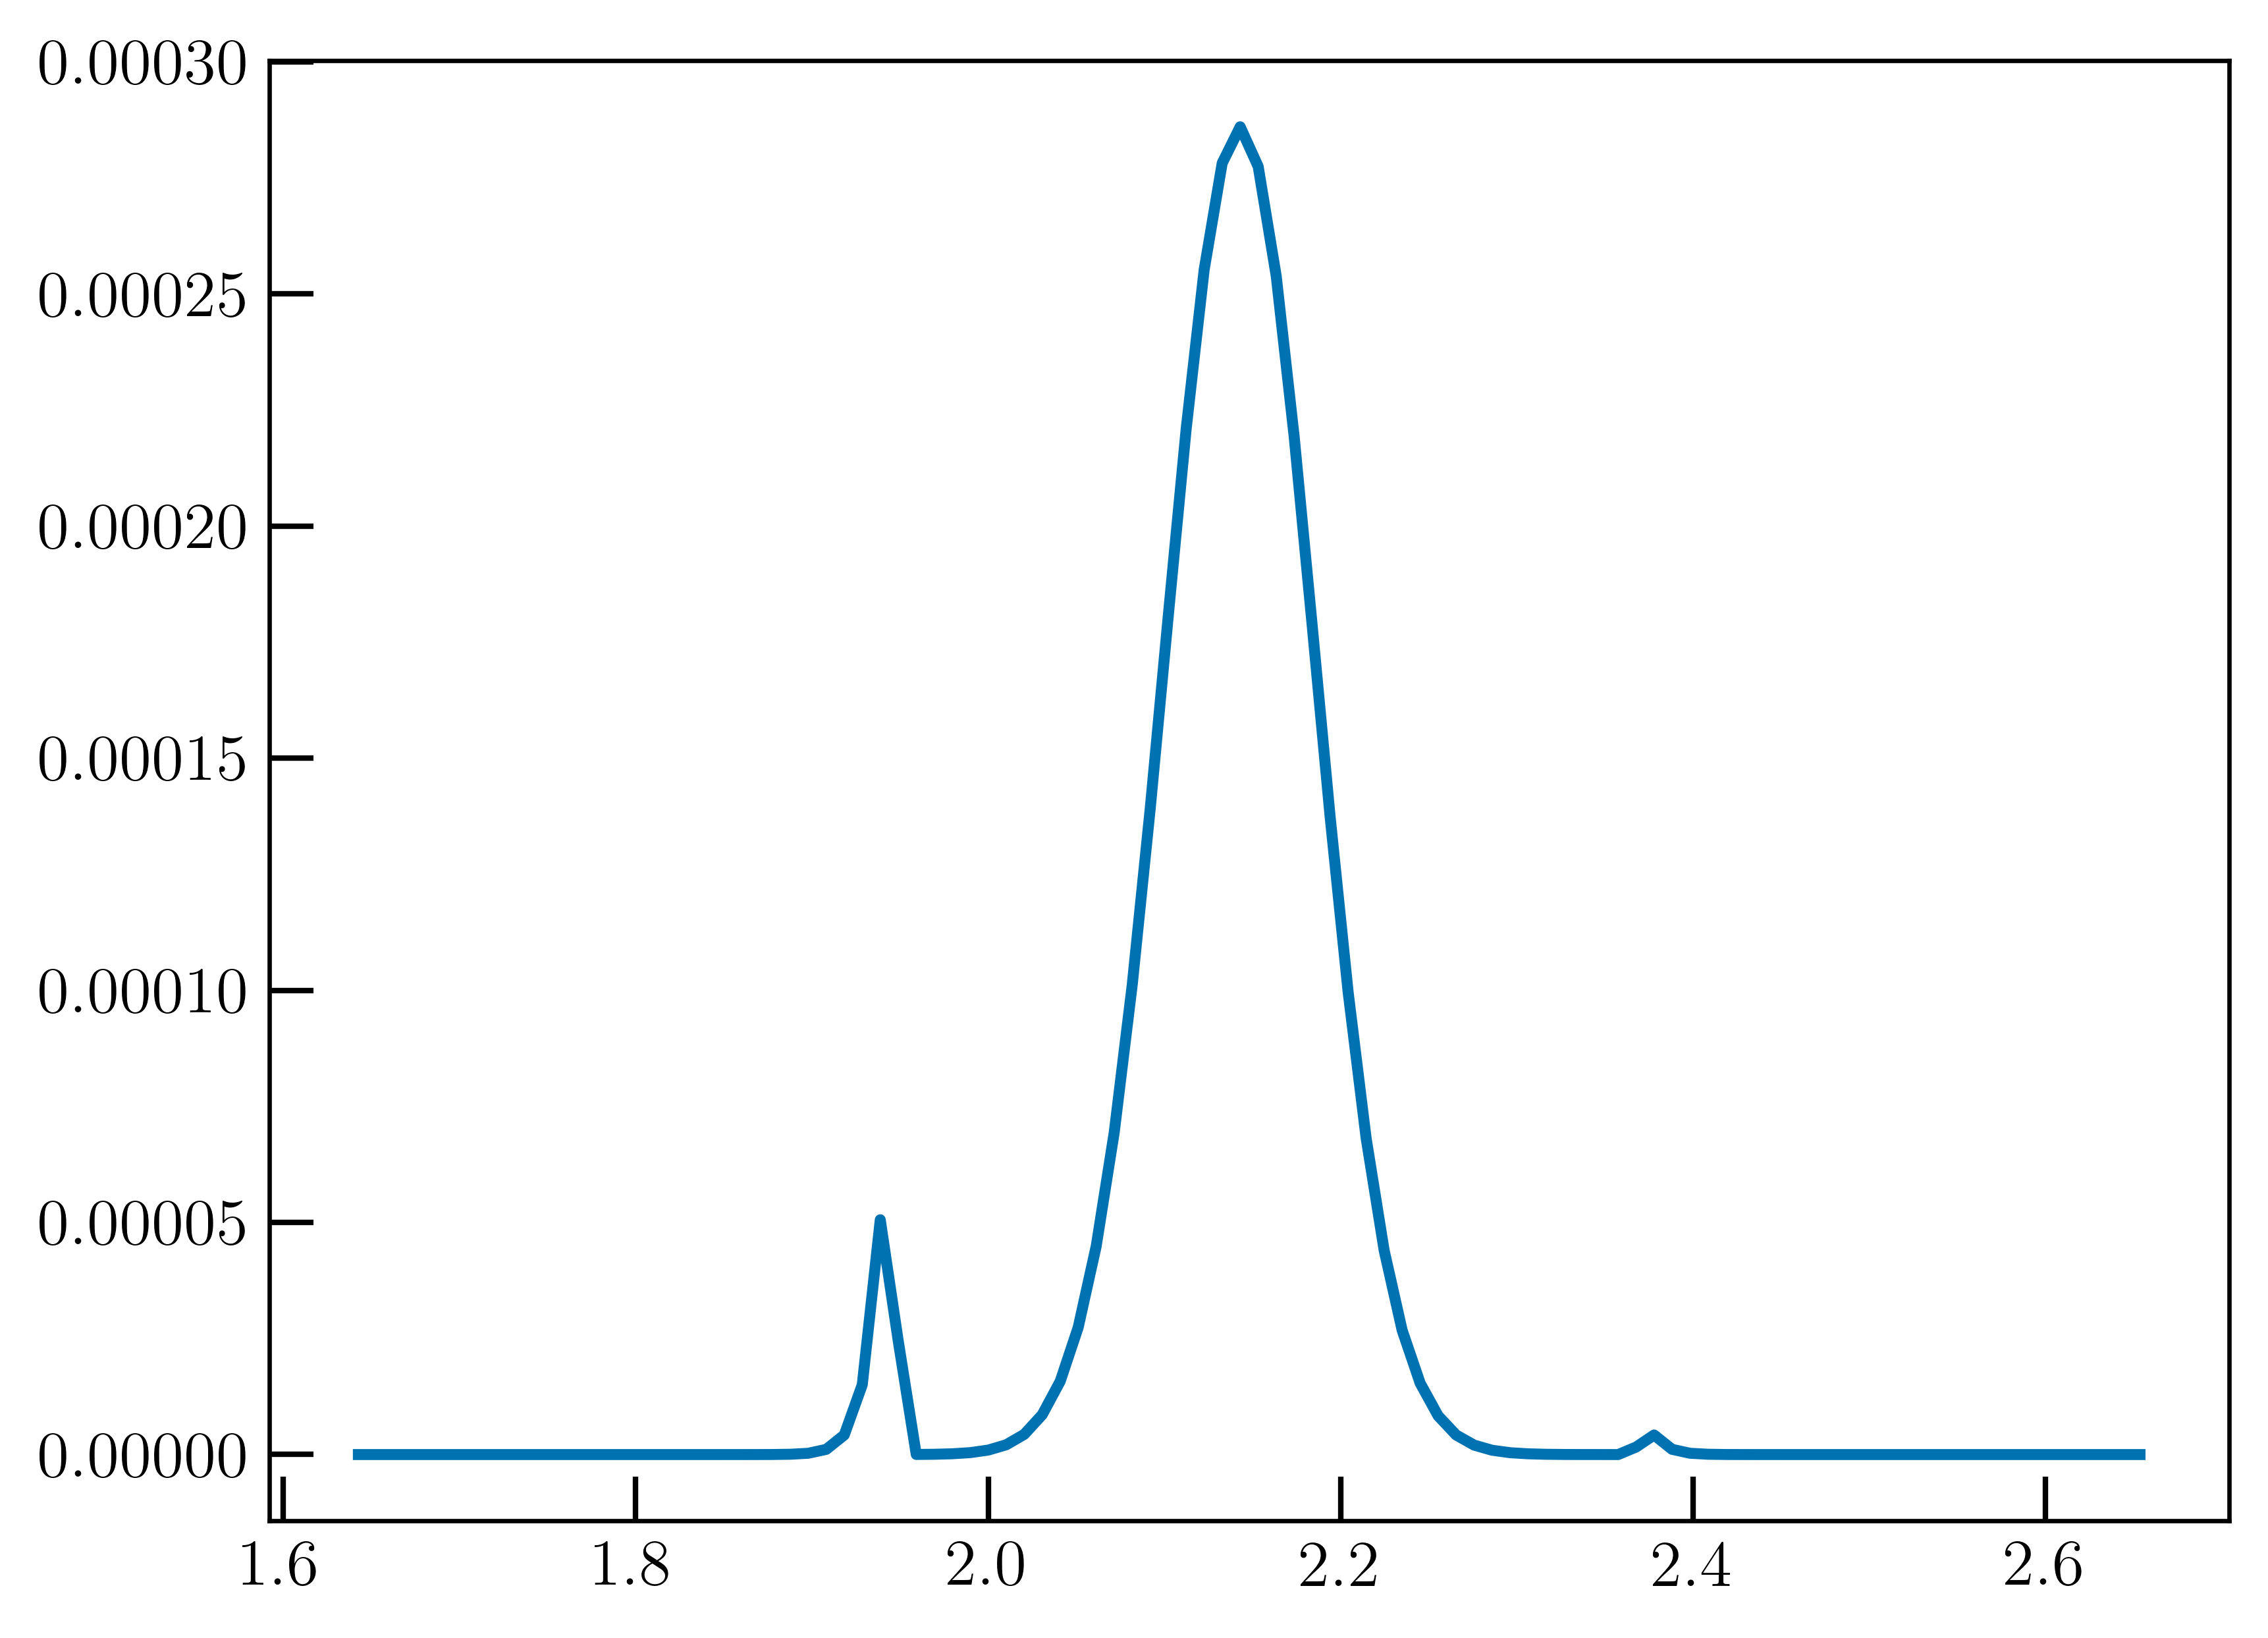

In [8]:
plt.plot(grid_rec, pdf_rec - analytical_pdf_rec)

We can see that the difference is on the $10^{-4}$ level for 1001 bins on E_vis, well suitable for a fast evaluation. Now we stick to the matrix multiplication method, and see how the three detector effects (IBD, non-linearily, smearing) build up for a complete detector model.

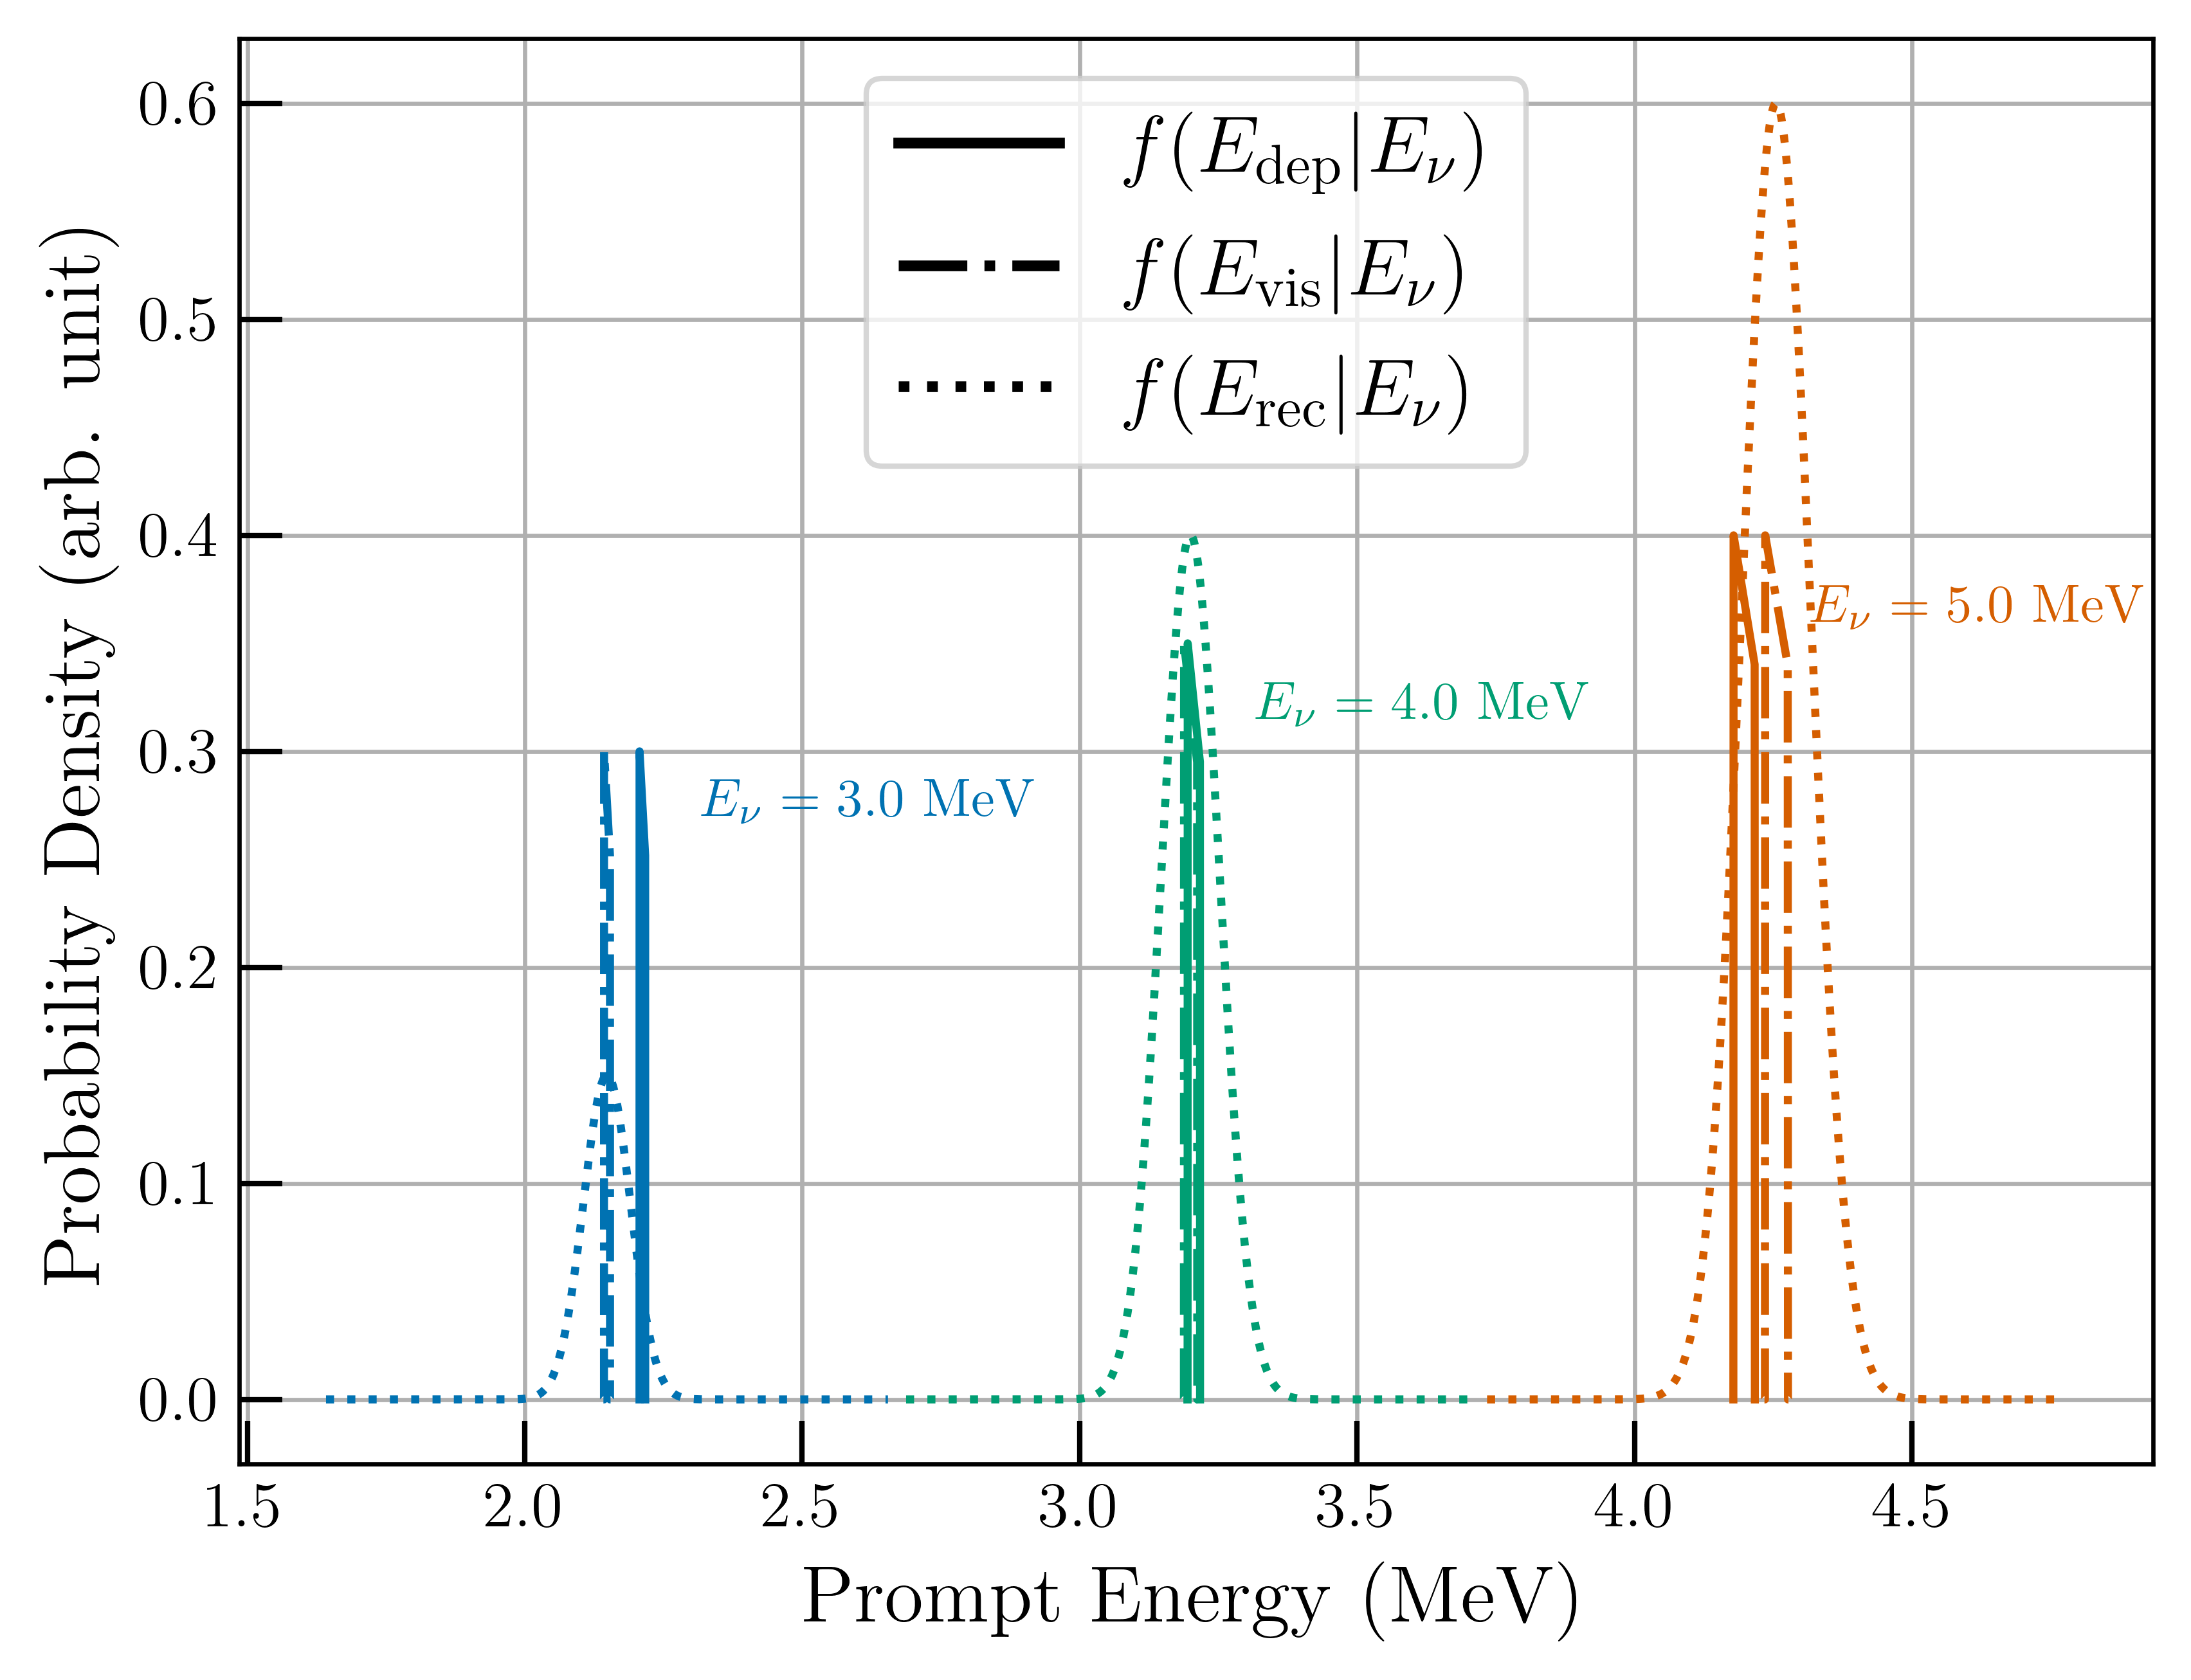

In [17]:
E_nu_list = [3.0, 4.0, 5.0]
color_list = ["C0", "C1", "C2"]
norm = {
    3.0: {"E_dep": 0.3, "E_vis": 0.3, "E_rec": 0.15},
    4.0: {"E_dep": 0.35, "E_vis": 0.35, "E_rec": 0.4},
    5.0: {"E_dep": 0.4, "E_vis": 0.4, "E_rec": 0.6},
}

# plt.figure(figsize=(10, 6))
for color, E_nu in zip(color_list, E_nu_list):
    # Plot f(E_dep|E_nu), box-like
    E_dep_min, E_dep_max = np.array(sv.get_kinematic_bounds(E_nu)) + sv.m_e
    E_dep_min = E_dep_min[0]
    E_dep_max = E_dep_max[0]
    E_dep = np.linspace(E_dep_min - 1e-5, E_dep_max + 1e-5, 100)
    dep_pdf = sv.get_E_dep_pdf(E_nu, E_dep)
    plt.plot(
        E_dep,
        dep_pdf / np.max(dep_pdf) * norm[E_nu]["E_dep"],
        linestyle="solid",
        c=color,
        lw=1.5,
    )
    E_vis = np.linspace(
        juno_detector.spline_dep_to_vis(E_dep_min) - 1e-3,
        juno_detector.spline_dep_to_vis(E_dep_max) + 1e-3,
        100,
    )
    vis_pdf = juno_detector.get_E_vis_pdf(sv.get_E_dep_pdf)(E_nu, E_vis)
    plt.plot(
        E_vis,
        vis_pdf / np.max(vis_pdf) * norm[E_nu]["E_vis"],
        linestyle="dashdot",
        c=color,
        lw=1.5,
    )
    E_vis_grid = np.linspace(
        juno_detector.spline_dep_to_vis(E_dep_min) - 1e-3,
        juno_detector.spline_dep_to_vis(E_dep_max) + 1e-3,
        1001,
    )
    E_rec_grid = np.linspace(E_vis.min() - 0.5, E_vis.max() + 0.5, 1001)
    pdf_rec_grid = juno_detector.get_E_rec_pdf_grid(
        E_vis_grid,
        E_rec_grid,
        juno_detector.get_E_vis_pdf(sv.get_E_dep_pdf)(E_nu, E_vis_grid),
    )
    plt.plot(
        E_rec_grid,
        pdf_rec_grid / np.max(pdf_rec_grid) * norm[E_nu]["E_rec"],
        linestyle="dotted",
        c=color,
        lw=1.5,
    )
    plt.text(
        E_dep_max + 0.1,
        norm[E_nu]["E_dep"] * 0.9,
        f"$E_\\nu={E_nu}$ MeV",
        color=color,
        fontsize=10,
    )

plt.xlabel("Prompt Energy (MeV)")
plt.ylabel("Probability Density (arb. unit)")
# plt.title("IBD Kinematics and JUNO Detector Response")
handles = [
    plt.Line2D([0], [0], color="black", linestyle="solid"),
    plt.Line2D([0], [0], color="black", linestyle="dashdot"),
    plt.Line2D([0], [0], color="black", linestyle="dotted"),
]
plt.legend(
    handles,
    [
        r"$f(E_{\mathrm{dep}}|E_{\nu})$",
        r"$f(E_{\mathrm{vis}}|E_{\nu})$",
        r"$f(E_{\mathrm{rec}}|E_{\nu})$",
    ],
)

plt.grid()
plt.savefig("./plots/juno_full_detector_response.pdf", bbox_inches="tight")

We also wish to check the normalization of the pdfs.

In [10]:
E_dep_pdf = sv.get_E_dep_pdf
E_e_min, E_e_max = sv.get_kinematic_bounds(3.0)
E_dep_min = E_e_min[0] + sv.m_e
E_dep_max = E_e_max[0] + sv.m_e
E_dep_grid = np.linspace(E_dep_min, E_dep_max, 10000)
scipy.integrate.simpson(sv.get_E_dep_pdf(3.0, E_dep_grid), E_dep_grid)  # Should be 1.0

0.999963698320517

In [11]:
E_vis_min = juno_detector.spline_dep_to_vis(E_dep_min)
E_vis_max = juno_detector.spline_dep_to_vis(E_dep_max)
E_vis_grid = np.linspace(E_vis_min - 1e-3, E_vis_max + 1e-3, 10000)
E_vis_pdf = juno_detector.get_E_vis_pdf(sv.get_E_dep_pdf)
scipy.integrate.simpson(E_vis_pdf(3.0, E_vis_grid), E_vis_grid)  # Should be 1.0

0.9999407636368269

In [12]:
E_rec_grid = np.linspace(1.8, 2.5, 10000)
E_rec_pdf = juno_detector.get_E_rec_pdf_grid(
    E_vis_grid, E_rec_grid, E_vis_pdf(3.0, E_vis_grid)
)

# Manually use simpson's rule to check normalization
simpon_weights = np.ones_like(E_rec_grid)
simpon_weights[1:-1:2] = 4.0
simpon_weights[2:-2:2] = 2.0
dx = E_rec_grid[1] - E_rec_grid[0]
simpson_integral = (dx / 3.0) * np.sum(simpon_weights * E_rec_pdf)  # Should be 1.0
simpson_integral

0.9999407636363226

Finally, we construct the response matrix.

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:27<00:00, 108.95it/s]


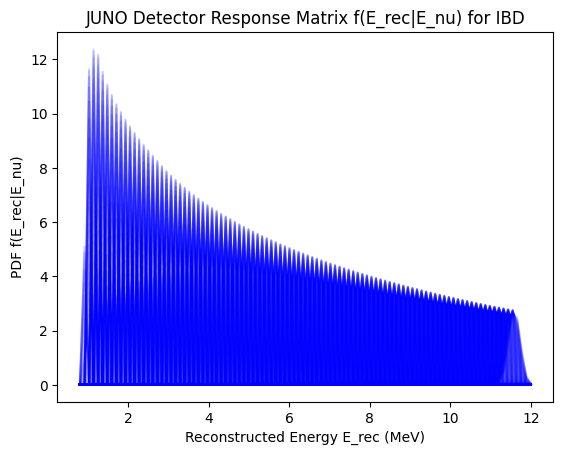

In [13]:
# Construct a matrix plot of f(E_rec|E_nu) for E_nu in [1.8, 12] MeV
# and E_rec in [1.5, 12] MeV
# matrix_f_Erec_Enu[i, j] = f(E_rec_j | E_nu_i)
# Matrix shape is (3000, 3000) = (N_rec, N_nu)
from tqdm import tqdm

grid_rec = np.linspace(0.8, 12.0, 100)
grid_nu = np.linspace(1.8, 12.0, 3000)

matrix_f_Erec_Enu = np.zeros((grid_rec.size, grid_nu.size))

for i, E_nu in enumerate(tqdm(grid_nu)):
    E_dep_pdf = sv.get_E_dep_pdf
    E_e_min, E_e_max = sv.get_kinematic_bounds(E_nu)
    E_dep_min = E_e_min[0] + sv.m_e
    E_dep_max = E_e_max[0] + sv.m_e
    E_vis_min = juno_detector.spline_dep_to_vis(E_dep_min)
    E_vis_max = juno_detector.spline_dep_to_vis(E_dep_max)
    # We compute the matrix-smearing result
    grid_vis = np.linspace(E_vis_min, E_vis_max, 1001)  # Grid for E_vis

    pdf_vis = juno_detector.get_E_vis_pdf(sv.get_E_dep_pdf)(E_nu, grid_vis)
    pdf_rec = juno_detector.get_E_rec_pdf_grid(grid_vis, grid_rec, pdf_vis)

    matrix_f_Erec_Enu[:, i] = pdf_rec

    plt.plot(grid_rec, pdf_rec, color="blue", alpha=0.1)

plt.xlabel("Reconstructed Energy E_rec (MeV)")
plt.ylabel("PDF f(E_rec|E_nu)")
plt.title("JUNO Detector Response Matrix f(E_rec|E_nu) for IBD")
plt.show()

# np.savez_compressed('juno_detector_response_matrix.npz', E_nu_grid=grid_nu, E_rec_grid=grid_rec, f_Erec_Enu=matrix_f_Erec_Enu)

We see that the response is quite smooth and does not introduce extra wiggles. We proceed with building the full response matrix.

In [14]:
E_nu_grid = np.linspace(1.8, 12.0, 3000)
E_rec_grid = np.linspace(0.8, 12.0, 3000)
juno_detector.build_response_matrix(E_nu_grid, E_rec_grid, bins_E_vis=1001)
juno_detector.save_response_matrix()

Building Detector Response Matrix: 100%|██████████| 3000/3000 [04:44<00:00, 10.53it/s]


Response matrix saved to juno_detector_response_matrix_79665791.npz


In [15]:
# To load the saved response matrix later:
juno_detector.load_response_matrix()

Response matrix loaded from juno_detector_response_matrix_79665791.npz
